# Example2 - Real data set

In this second example we will explore more functionalities of the module with a dataset from a real building. The data was collected during a dynamic identification campaign conducted in 2019 and contains 6 channels of acceleration data sampled at 100 Hz. For more info about the instrumentation used and the building itself refer to **[APTF20](#ref-1)**..

First of all we import the necessary modules.
Then we import the dataset we want to analyse and assign it to a variable.
All the files needed to run this example are available [here](https://github.com/dagghe/pyOMA-test-data/tree/main/test_data/palisaden).

In [1]:
import numpy as np
from pyoma2.algorithms import FSDD, SSI, pLSCF
from pyoma2.setup import SingleSetup
from pyoma2.support.utils.sample_data import get_sample_data

# load example dataset for single setup
data = np.load(get_sample_data(filename="Palisaden_dataset.npy", folder="palisaden"), allow_pickle=True)

2025-06-07 22:27:52,924 - pyoma2.support.utils.sample_data - INFO - Palisaden_dataset.npy already exists locally. (sample_data:49)


 Now we can proceed to instantiate the SingleSetup class, passing the dataset and the sampling frequency as parameters

In [2]:
# create single setup
Pali_ss = SingleSetup(data, fs=100)

If we want to be able to plot the mode shapes, once we have the results, we need to define the geometry of the structure.
We have two different method available that offers unique plotting capabilities:
* The first method ```def_geo1()``` enables users to visualise mode shapes with arrows that represent the placement, direction, and magnitude of displacement for each sensor.
* The second method ```def_geo2()``` allows for the plotting and animation of mode shapes, with sensors mapped to user defined points.

In [3]:
_geo1 =  get_sample_data(filename="Geo1.xlsx", folder="palisaden")
_geo2 =  get_sample_data(filename="Geo2.xlsx", folder="palisaden")

Pali_ss.def_geo1_by_file(_geo1)
Pali_ss.def_geo2_by_file(_geo2)

2025-06-07 22:27:52,942 - pyoma2.support.utils.sample_data - INFO - Geo1.xlsx already exists locally. (sample_data:49)
2025-06-07 22:27:52,943 - pyoma2.support.utils.sample_data - INFO - Geo2.xlsx already exists locally. (sample_data:49)


Once we have defined the geometry we can show it calling the ```plot_geo1()``` or ```plot_geo2()``` methods.

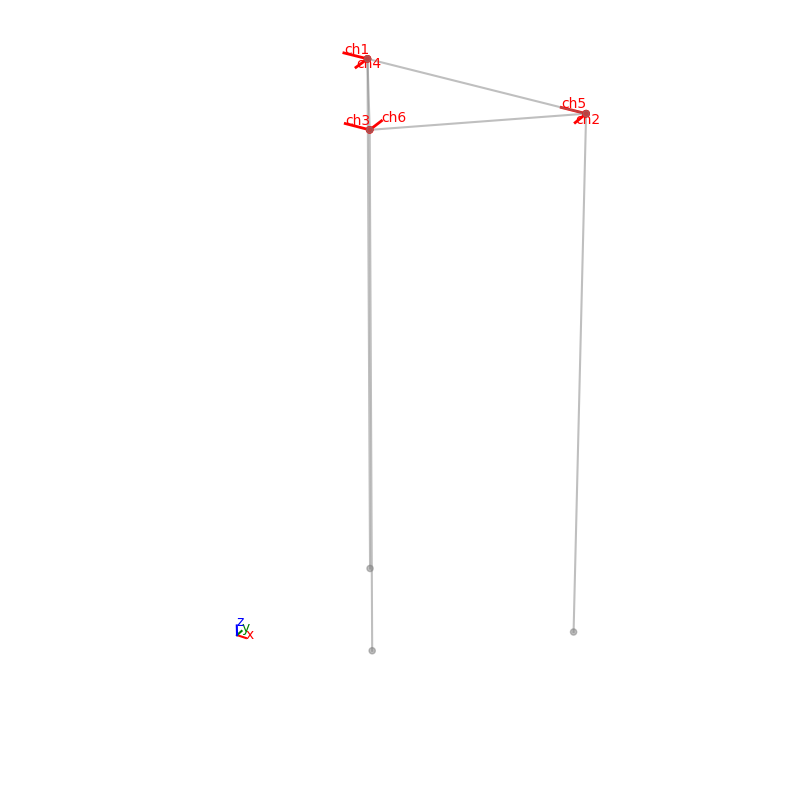

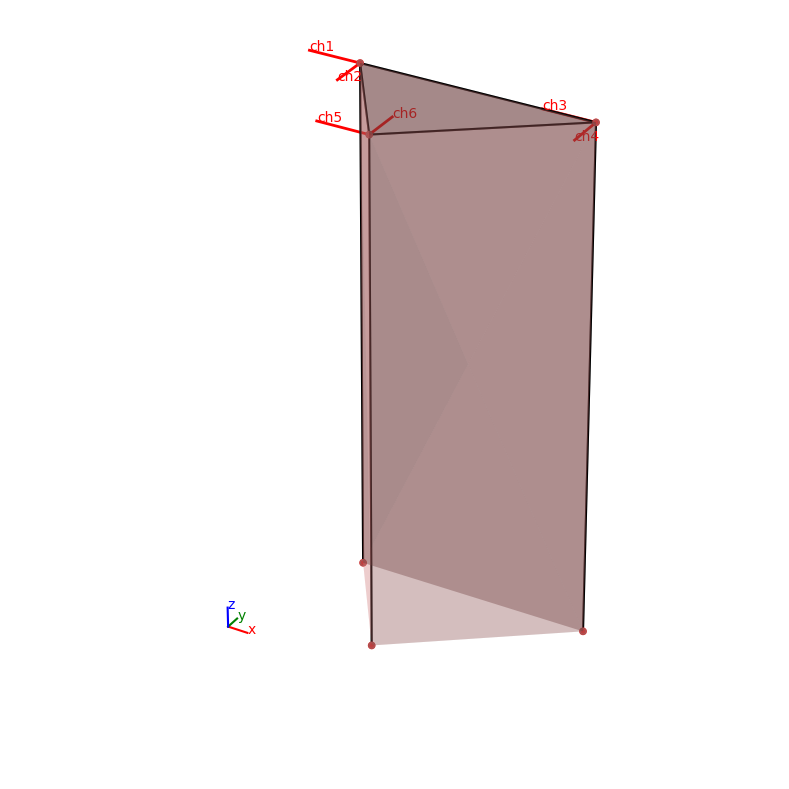

In [4]:
# Plot the geometry (geometry1)
fig, ax = Pali_ss.plot_geo1()
# (geometry2) with pyvista
_ = Pali_ss.plot_geo2(scaleF=2)
# (geometry2) with matplotlib
_, _ = Pali_ss.plot_geo2_mpl(scaleF=2)

We can plot all the time histories of the channels calling the ```plot_data()``` method

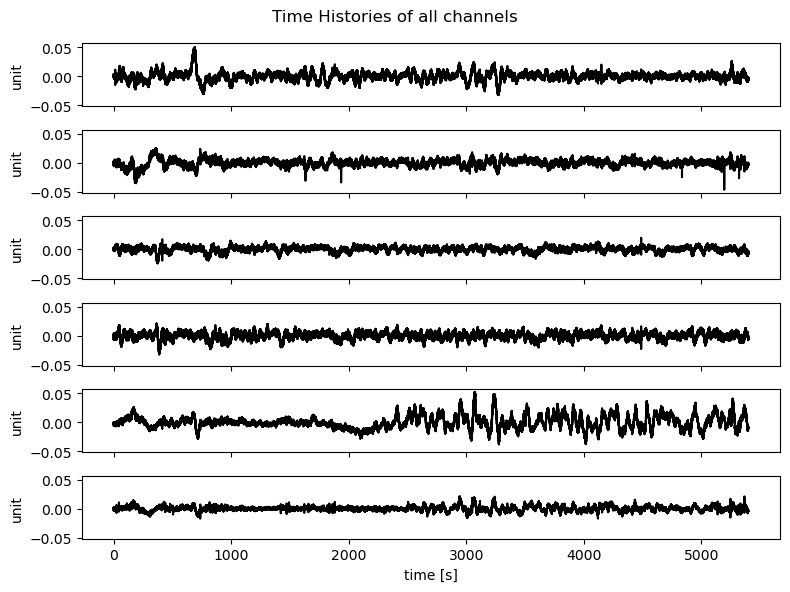

In [5]:
# Plot the Time Histories
_, _ = Pali_ss.plot_data()

We can also get more info regarding the quality of the data for a specific channel calling the ```plot_ch_info()``` method

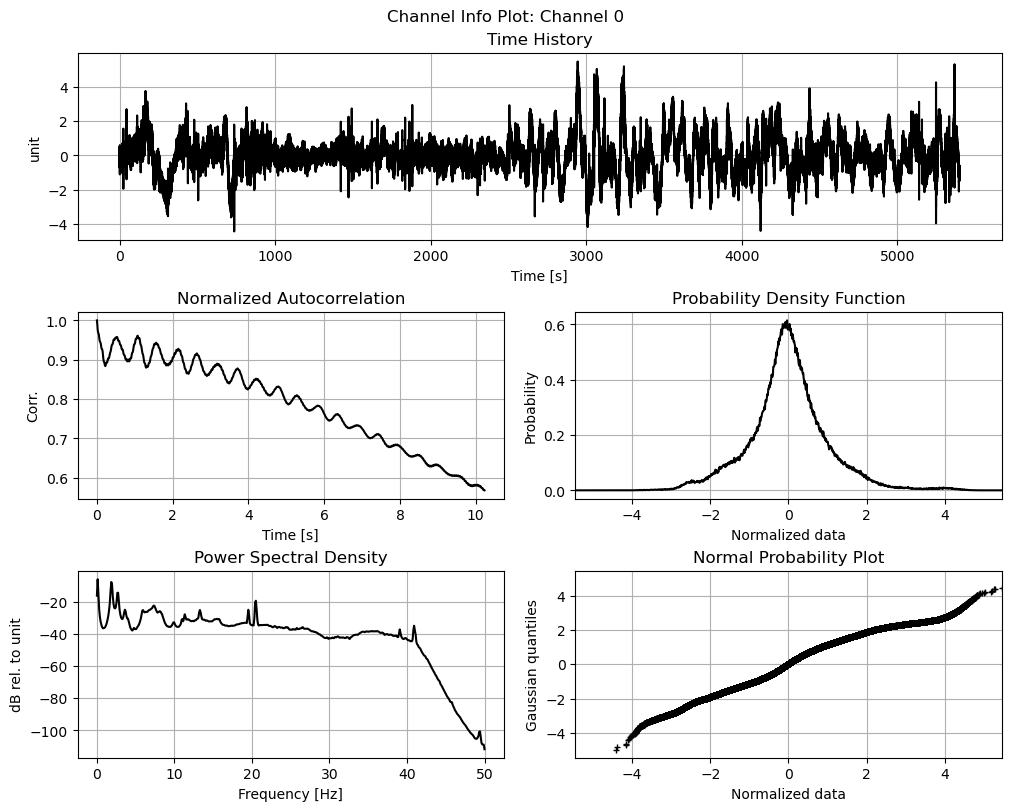

In [6]:
# Plot TH, PSD and KDE of the (selected) channels
_, _ = Pali_ss.plot_ch_info(ch_idx=[-1])

As we can see from the auto correlation there's a low frequency component in the data. 

Other than the ```detrend_data()``` and ```decimate_data()``` methods there's also a ```filter_data()```
method that can help us here. 

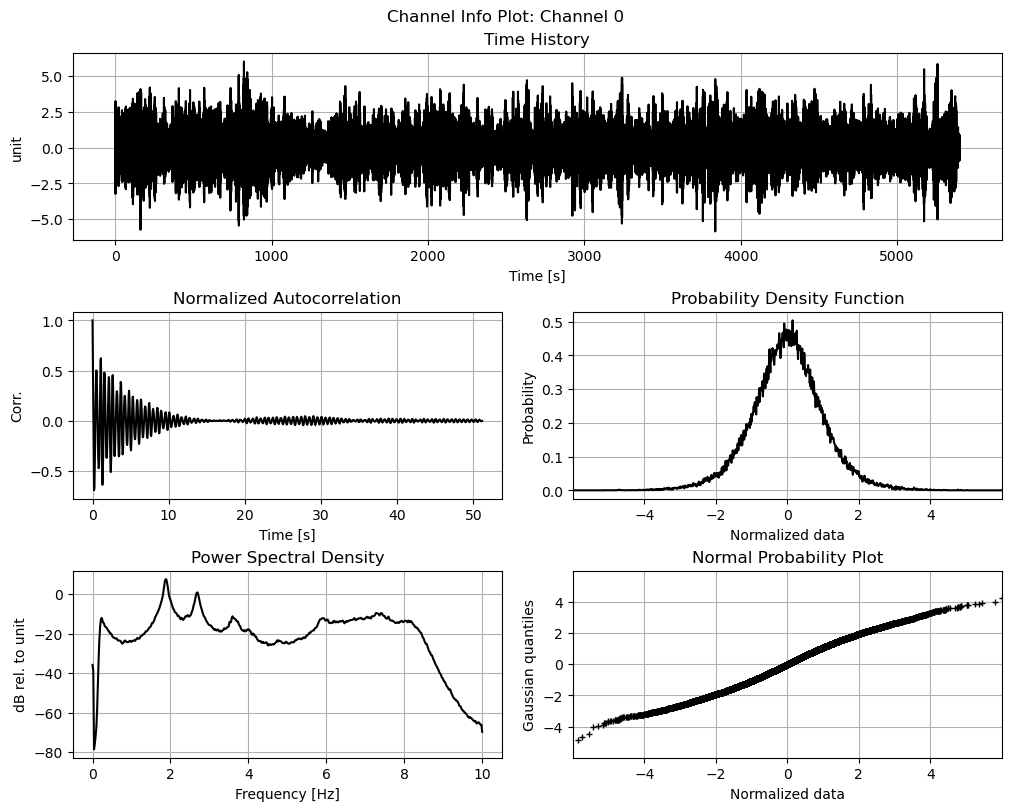

In [7]:
# Detrend and decimate
#Pali_ss.detrend_data()
Pali_ss.filter_data(Wn=(0.2), order=8, btype="highpass")
Pali_ss.decimate_data(q=5)
_, _ = Pali_ss.plot_ch_info(ch_idx=[-1])

We need now to instantiate the algorithms that we want to run, e.g. ```FSDD``` and ```SSIcov```. The algorithms must then be added to the setup class using the
```add_algorithms()``` method.
Thereafter, the algorithms can be executed either individually using the ```run_by_name()``` method or collectively with ```run_all()```.

In [8]:
# Initialise the algorithms
fsdd = FSDD(name="FSDD", nxseg=1024, method_SD="cor")
ssicov = SSI(name="SSIcov", method="cov", br=30, ordmax=50, calc_unc=True, step=2)
plscf = pLSCF(name="polymax", ordmax=30)

# Overwrite/update run parameters for an algorithm
fsdd.run_params = FSDD.RunParamCls(nxseg=2048, method_SD="per", pov=0.5)

# Add algorithms to the single setup class
Pali_ss.add_algorithms(ssicov, fsdd, plscf)

# Run all or run by name
Pali_ss.run_by_name("SSIcov")
Pali_ss.run_by_name("FSDD")
Pali_ss.run_by_name("polymax")
# Pali_ss.run_all()

# save dict of results
ssi_res = ssicov.result.model_dump()
fsdd_res = dict(fsdd.result)

2025-06-07 22:27:55,554 - pyoma2.setup.base - INFO - Running SSIcov... (base:123)
2025-06-07 22:27:55,554 - pyoma2.functions.ssi - INFO - Assembling Hankel matrix method: cov... (ssi:89)
2025-06-07 22:27:55,769 - pyoma2.functions.ssi - INFO - ... calculating cov(H)... (ssi:100)
2025-06-07 22:27:55,961 - pyoma2.functions.ssi - INFO - SSI for increasing model order... (ssi:462)
100%|██████████| 26/26 [00:00<00:00, 19845.66it/s]
2025-06-07 22:27:55,985 - pyoma2.functions.ssi - INFO - ... propagating uncertainty... (ssi:590)
100%|██████████| 25/25 [00:00<00:00, 41.09it/s]
2025-06-07 22:27:56,595 - pyoma2.functions.ssi - INFO - Calculating modal parameters for increasing model order... (ssi:628)
100%|██████████| 26/26 [00:00<00:00, 47.68it/s] 
2025-06-07 22:27:57,185 - pyoma2.setup.base - INFO - Running FSDD... (base:123)
2025-06-07 22:27:57,227 - pyoma2.setup.base - INFO - Running polymax... (base:123)
100%|██████████| 30/30 [00:00<00:00, 31.38it/s]


We can now plot some of the results:

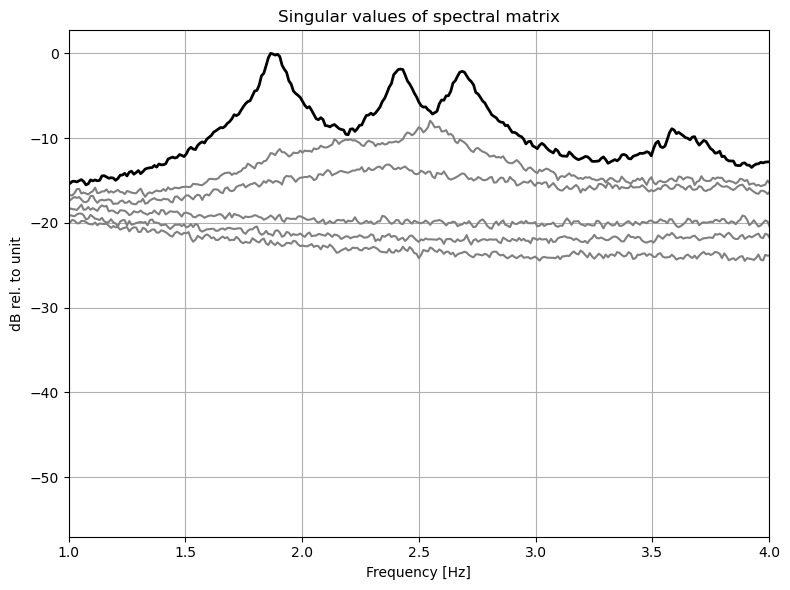

In [9]:
# plot Singular values of PSD
_, _ = fsdd.plot_CMIF(freqlim=(1,4))

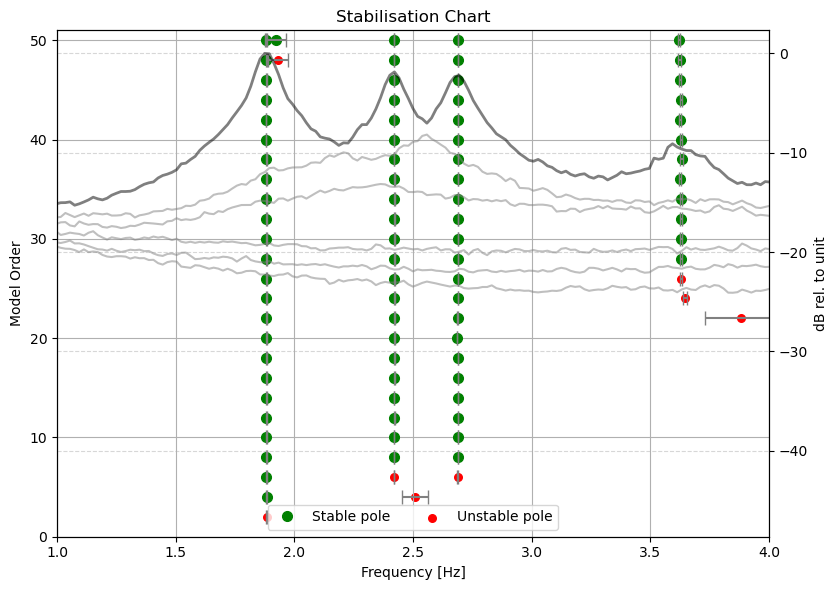

In [10]:
# plot Stabilisation chart for SSI
_, _ = ssicov.plot_stab(freqlim=(1,4), hide_poles=False, spectrum=True)

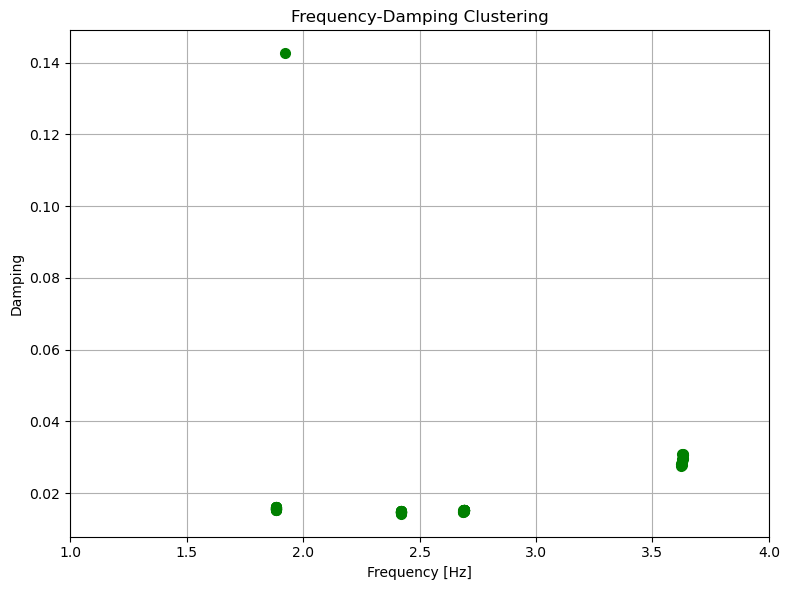

In [11]:
# plot frequecy-damping clusters for SSI
_, _ = ssicov.plot_freqvsdamp(freqlim=(1,4))

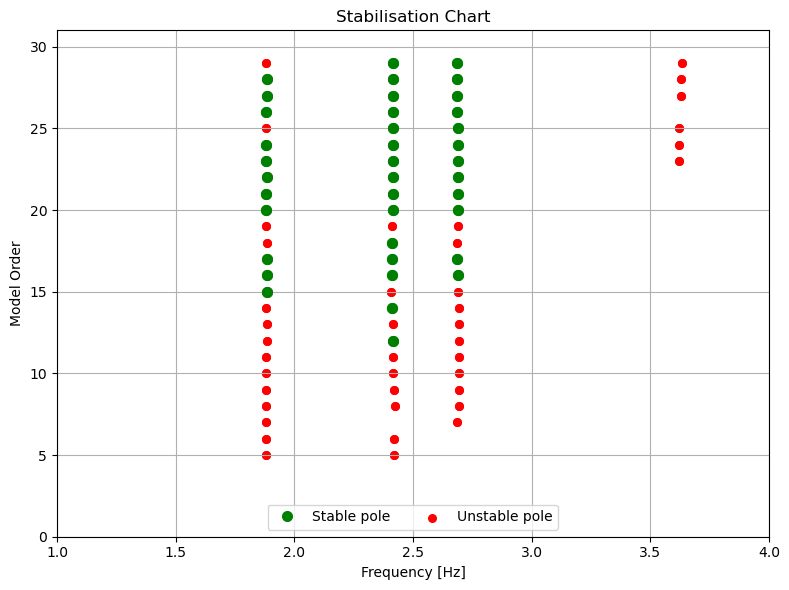

In [12]:
# plot Stabilisation chart for pLSCF
_, _ = plscf.plot_stab(freqlim=(1,4), hide_poles=False)

We are now ready to extract the modal properties of interest either from the interactive plots using the ```mpe_from_plot()``` method or using the ```mpe()``` method.

In [13]:
# Select modes to extract from plots
# Pali_ss.mpe_from_plot("SSIcov", freqlim=(1,4))

# or directly
Pali_ss.mpe("SSIcov", sel_freq=[1.88, 2.42, 2.68], order_in=20)

# update dict of results
ssi_res = dict(ssicov.result)

2025-06-07 22:27:59,015 - pyoma2.setup.base - INFO - Getting mpe modal parameters from SSIcov (base:149)
2025-06-07 22:27:59,016 - pyoma2.functions.ssi - INFO - Extracting SSI modal parameters (ssi:1036)
100%|██████████| 3/3 [00:00<00:00, 17427.86it/s]


In [14]:
# Select modes to extract from plots
# Pali_ss.mpe_from_plot("FSDD", freqlim=(1,4), MAClim=0.95)

# or directly
Pali_ss.mpe("FSDD", sel_freq=[1.88, 2.42, 2.68], MAClim=0.95)

# update dict of results
fsdd_res = dict(fsdd.result)

2025-06-07 22:27:59,026 - pyoma2.setup.base - INFO - Getting mpe modal parameters from FSDD (base:149)
2025-06-07 22:27:59,045 - pyoma2.functions.fdd - INFO - Extracting FDD modal parameters (fdd:285)
100%|██████████| 3/3 [00:00<00:00, 18641.35it/s]
2025-06-07 22:27:59,133 - pyoma2.functions.fdd - INFO - EFDD extraction complete. (fdd:565)


We can compare the results from the two methods

In [15]:
ssicov.result.Fn

array([1.88201931, 2.42169542, 2.68703719])

In [16]:
fsdd.result.Fn

array([1.87664321, 2.42224461, 2.68230238])

We can also plot some additional info regarding the estimates for the EFDD and FSDD algorithms

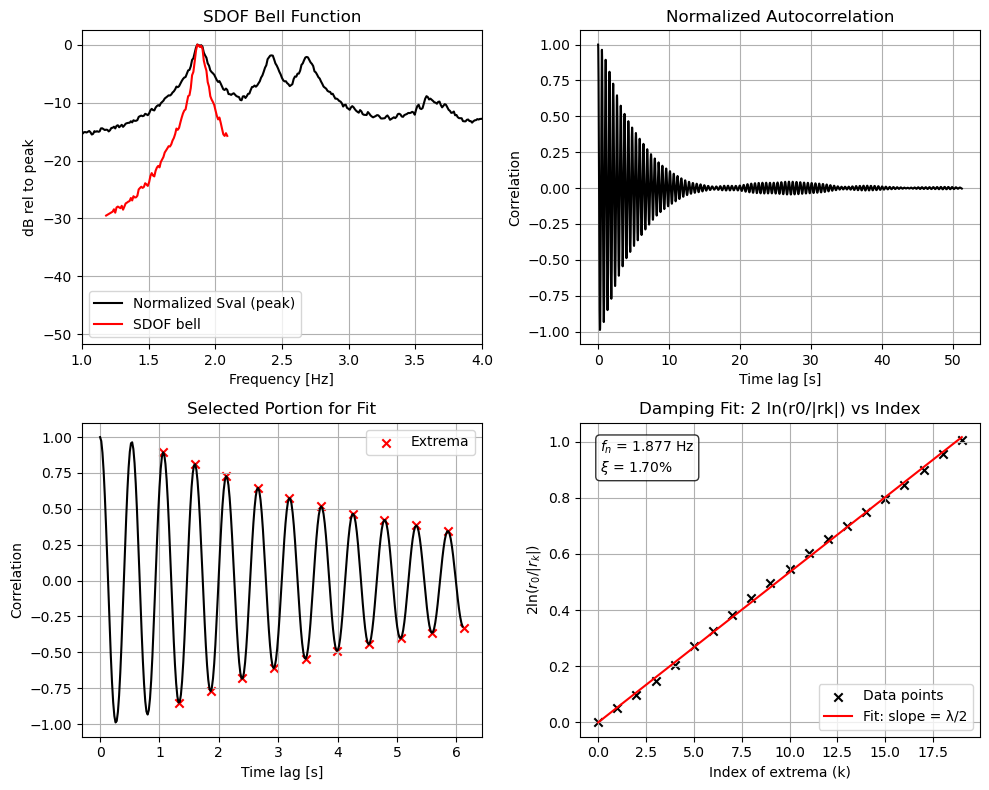

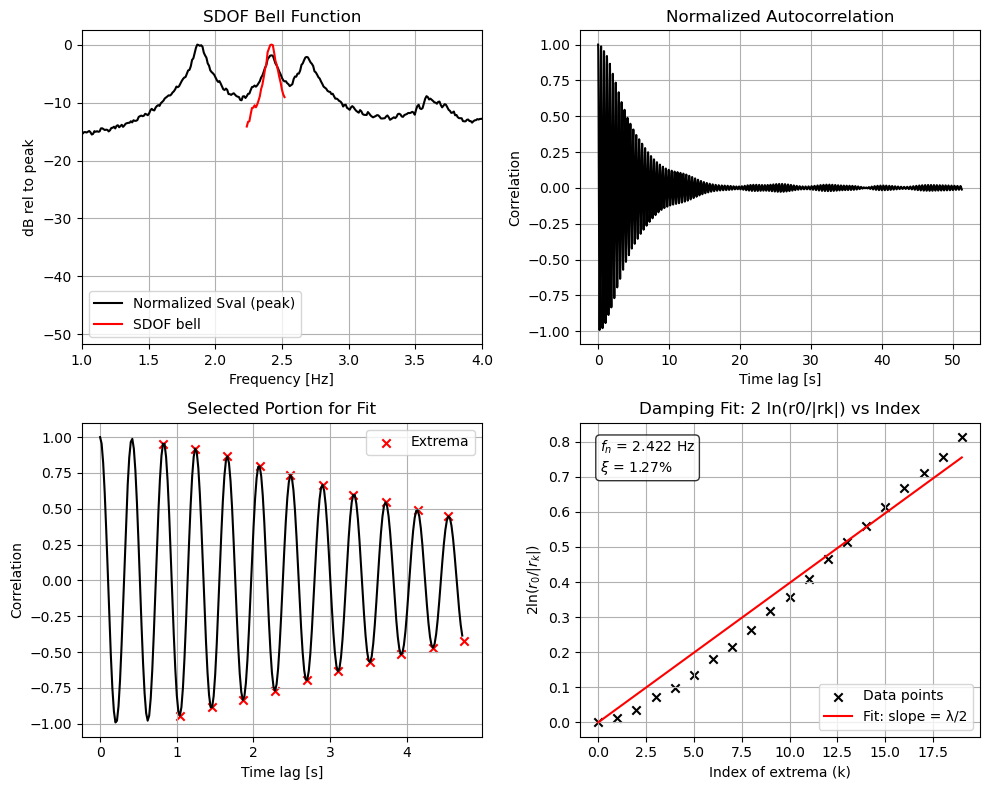

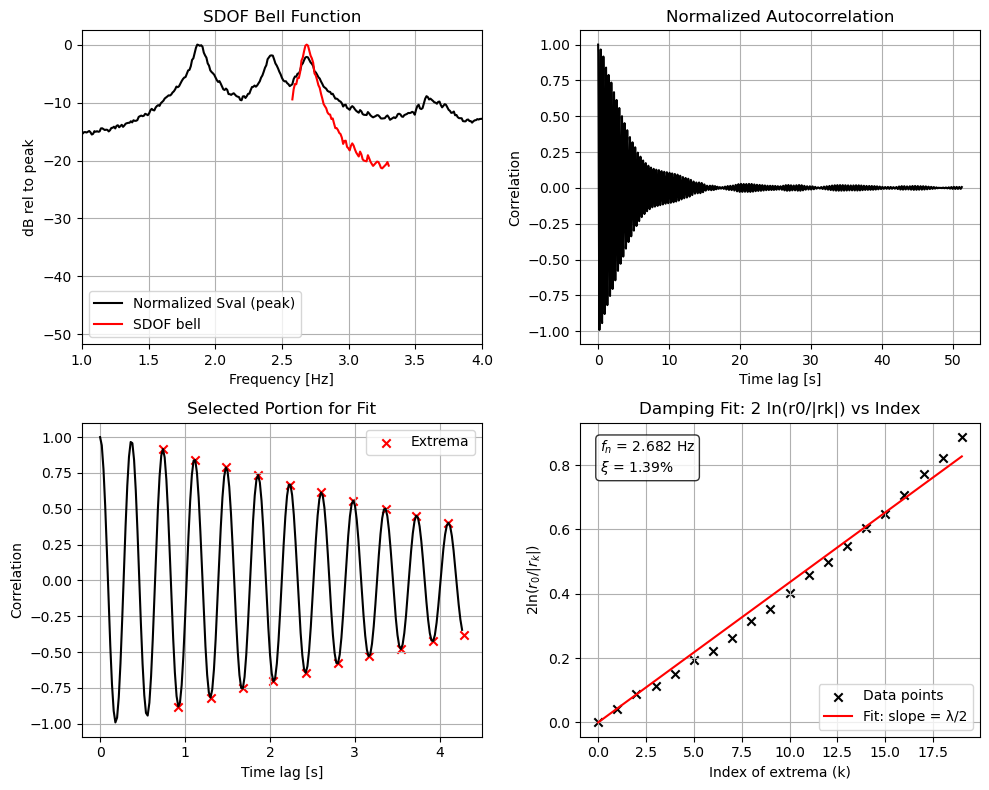

In [17]:
# plot additional info (goodness of fit) for EFDD or FSDD
_, _ = Pali_ss[fsdd.name].plot_EFDDfit(freqlim=(1,4))

And finally we can plot and/or animate the mode shapes extracted from the analysis

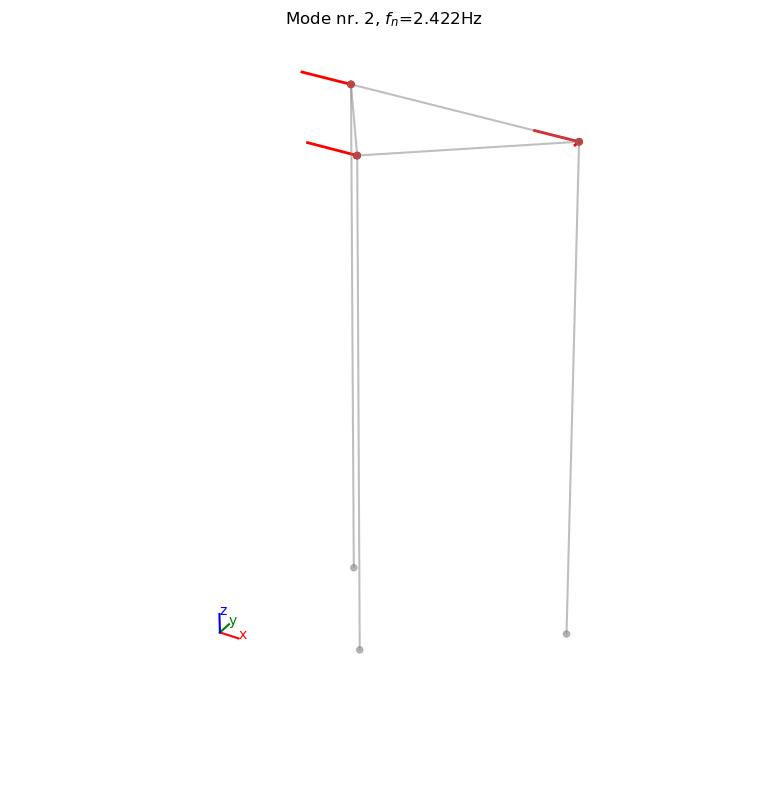

In [18]:
# MODE SHAPES PLOT
# Plot mode 2 (geometry 1)
_, _ = Pali_ss.plot_mode_geo1(algo_res=fsdd.result, mode_nr=2, view="3D", scaleF=2)

In [19]:
# Animate mode 1 (geometry 2)
_ = Pali_ss.anim_mode_geo2(
    algo_res=ssicov.result, mode_nr=1, scaleF=3)

It is also possible to save and load the results to a pickled file.

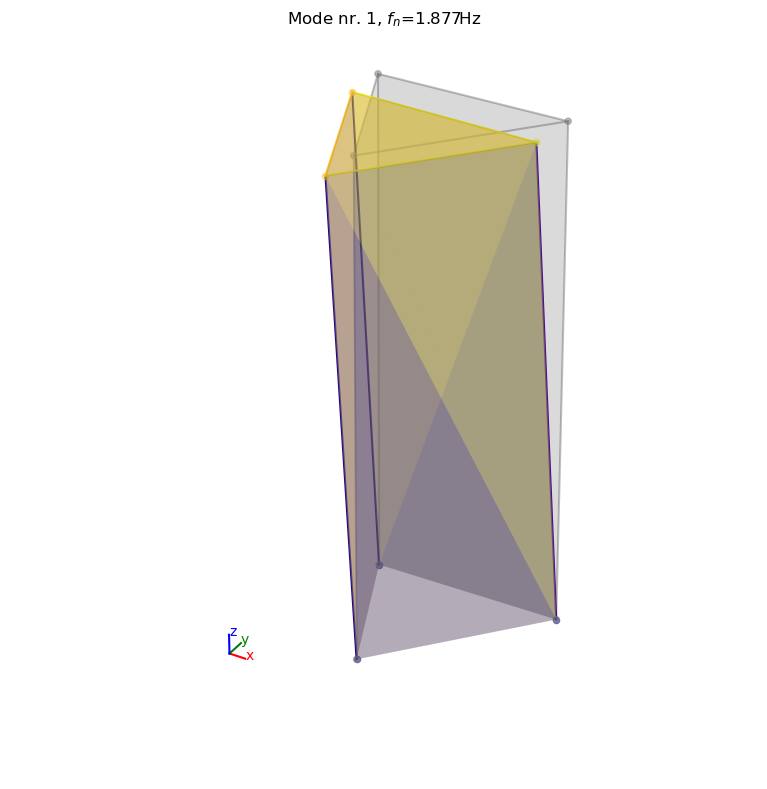

In [20]:
import os
import sys
import pathlib
# Add the directory we executed the script from to path:
sys.path.insert(0, os.path.realpath('__file__'))

from pyoma2.functions.gen import save_to_file, load_from_file

# Save setup
save_to_file(Pali_ss, pathlib.Path(r"./test.pkl"))

# Load setup 
pali2: SingleSetup = load_from_file(pathlib.Path(r"./test.pkl"))

# plot from loded instance
_, _ = pali2.plot_mode_geo2_mpl(
    algo_res=fsdd.result, mode_nr=1, view="3D", scaleF=2)

In [21]:
# delete file
os.remove(pathlib.Path(r"./test.pkl"))

## References
<a id="ref-1"></a>[APTF20] Aloisio, A., Pasca, D., Tomasi, R., & Fragiacomo, M. (2020). Dynamic identification and model updating of an eight-storey CLT building. Engineering Structures, 213, 110593.